In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


## Q1 : How many tennis players are included in the dataset?

In [ ]:
# check if you have not missing value
home_team = pd.read_csv("tennis_data/home_team.csv")
away_team = pd.read_csv("tennis_data/away_team.csv")
home_team = home_team[['full_name','player_id']]
away_team = away_team[['full_name','player_id']]
all_teams = pd.concat([home_team , away_team] ,join = 'outer')
all_teams.drop_duplicates(subset=['player_id'] , inplace = True)
all_teams.sort_values('full_name' , inplace = True)
all_teams.reset_index(drop=True , inplace = True)
num_players = all_teams['player_id'].nunique()
print(f'the number of players is: {num_players}')
all_teams

## Q2 : What is the average height of the players?

In [ ]:

# Reading the file csv
df_1 = pd.read_csv(f"tennis_data/away_team.csv")
df_2 = pd.read_csv(f"tennis_data/home_team.csv")

# Concatenate two csv files
merge_data = pd.concat([df_1,df_2], ignore_index=True)

# Filtering the available data based on needs and removing duplicate data and nan data in the height column
final_data = merge_data[["match_id", "full_name" , "player_id", "height"]].drop_duplicates(subset='player_id').dropna(subset=['height'])

# Calculate the mean height of the players
mean_height = final_data['height'].mean()
'The mean height of the players is '+ str(mean_height) + ' ' + 'm'

# Added plot
plt.figure(figsize=(6,4))
plt.boxplot(final_data['height'], vert=False)
plt.title("Boxplot of Player Heights")
plt.xlabel("Height (m)")
plt.grid()
plt.show()

## Q3 : Which player has the highest number of wins?

In [ ]:
home_team = pd.read_csv("tennis_data/home_team.csv")
away_team = pd.read_csv("tennis_data/away_team.csv")
event = pd.read_csv("tennis_data/event.csv")

home_team = home_team[['match_id','player_id' ,'full_name']]
away_team = away_team[['match_id','player_id' ,'full_name']]

all_home = home_team.drop_duplicates(subset = ['match_id'])
all_away = away_team.drop_duplicates(subset = ['match_id'])
all_play = pd.concat([all_home , all_away])
all_play = all_play.groupby('full_name').agg(
    num_game = ('player_id' , 'count')
)

players = pd.merge(home_team , away_team , how = "inner" , on = "match_id" , suffixes=["_home" , "_away"])
players.drop_duplicates(subset = ['match_id'] , inplace = True)


event = event[event['winner_code'].notnull()].drop_duplicates(subset=['match_id']).sort_values('match_id')
event = event[['match_id' , 'winner_code']]
event.reset_index(drop=True , inplace = True)
    
final = pd.merge(players , event , on = 'match_id' , how = 'inner')
final_home = final[final['winner_code'] == 1.0].copy()
final_away = final[final['winner_code'] == 2.0].copy()
final_home = final_home[['full_name_home' , 'player_id_home']].sort_values('full_name_home').rename(columns={'player_id_home':'player_id' , 'full_name_home' :'full_name'})
final_away = final_away[['full_name_away' , 'player_id_away']].sort_values('full_name_away').rename(columns={'player_id_away':'player_id' , 'full_name_away' :'full_name'})

final = pd.concat([final_home , final_away])
final.sort_values('full_name' , inplace = True)
final = final.groupby('full_name').agg(
    num_won = ('player_id' , 'count')
)

final = pd.merge(final , all_play , on = 'full_name' , how = 'left')
final['win_percentage'] = final['num_won'].div(final['num_game']) * 100
final.sort_values('win_percentage' , ascending=False , inplace = True)
final.reset_index(inplace  = True)

# visualization
df_melted = final.sample(3).melt(id_vars="full_name", value_vars=["win_percentage" , "num_won", "num_game"],
                    var_name="metric", value_name="value")

ax = sns.barplot(data=df_melted, x="full_name", y="value", hue="metric")
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f'{height:.1f}',    
        (p.get_x() + p.get_width() / 2, height),
        ha='center',
        va='bottom',
        fontsize=9
    )
plt.title("Wins vs Games")
plt.show()
final

## Q5 : How many sets are typically played in a tennis match?

In [ ]:
# import data and clear
time = pd.read_csv("tennis_data/time.csv")
time.drop_duplicates(subset = ['match_id'] , inplace=True)
time.dropna(subset = ['period_1'] , inplace = True)
time.dropna(subset = ['period_2'] , inplace = True)

# check if you have period_4 or period_5
print(time['period_4'].notnull().any())
print(time['period_5'].notnull().any())

# drop period_4 and period_5 and fill null with 0
time.drop(['period_4' , 'period_5' ,'current_period_start_timestamp']  , axis = 'columns', inplace = True )
values = {'period_3':0}
time.fillna(value = values , inplace = True)
time.loc[time['period_3'] == 0 , 'num_set'] = 2
time.loc[time['period_3'] != 0 , 'num_set'] = 3
finall = time.groupby('num_set').agg(
    number_of_sets = ('num_set' , 'count')
)
total = finall['number_of_sets'].sum()
finall['number_of_set_percentage'] = (finall['number_of_sets'].div(total)) * 100
finall.reset_index(inplace=True)

labels = ['2-Set Matches', '3-Set Matches']

plt.figure(figsize=(6,6))
plt.pie(finall['number_of_set_percentage'], labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Percentage of 2-Set vs 3-Set Matches')
plt.show()
finall

## Q6 : Which country has produced the most successful tennis players?

In [ ]:
# Read away\home team data with required columns
df_away_team = pd.read_csv(f"tennis_data/away_team.csv")[['match_id','full_name','country']]
df_home_team = pd.read_csv(f"tennis_data/home_team.csv")[['match_id','full_name','country']]

# Read event data including winner code
df_event = pd.read_csv(f"tennis_data/event.csv")

# Add a column to distinguish team type
df_away_team['team_type'] = 'away'
df_home_team['team_type'] = 'home'

# Merge home and away team data on match_id; use suffixes to distinguish home/away columns and remove duplicate matches
players = df_home_team.merge(df_away_team, on='match_id', suffixes=['_home','_away'], how='outer')
players.drop_duplicates(subset='match_id', inplace=True)

# Merge players with event results to include winner information and drop rows with missing winner or country information
merge_df = players.merge(df_event[['match_id', 'winner_code']], on='match_id')
merge_df.dropna(subset=['winner_code','country_home','country_away'], inplace=True)

# Create boolean columns to indicate if home/away player won
merge_df['is_winner_home'] = (merge_df['winner_code'] == 1) & (merge_df['team_type_home'] == 'home')
merge_df['is_winner_away'] = (merge_df['winner_code'] == 2) & (merge_df['team_type_away'] == 'away')

# Remove duplicates after winner calculations
merge_df.drop_duplicates(subset='match_id', inplace=True)

# Aggregate wins for home players
final_df_home = merge_df.groupby(['match_id', 'full_name_home', 'country_home']).agg(
    wins=('is_winner_home', 'sum')
).reset_index()

# Aggregate wins for away players
final_df_away = merge_df.groupby(['match_id', 'full_name_away', 'country_away']).agg(
    wins=('is_winner_away', 'sum')
).reset_index()

# Standardize column names to combine home and away stats
final_df_home.rename(columns={'full_name_home':'full_name','country_home':'country'}, inplace=True)
final_df_away.rename(columns={'full_name_away':'full_name','country_away':'country'}, inplace=True)

# Combine home and away stats, calculate total matches and wins per country
final_df = pd.concat([final_df_home, final_df_away]).groupby('country').agg(
    total_match=('match_id','nunique'),
    total_wins=('wins','sum')
).reset_index()

# Sort countries by total wins
final_df.sort_values(by='total_wins', ascending=False, inplace=True)

# Calculate win percentage per country
final_df['Percentage'] = (final_df['total_wins'] / final_df['total_match'] * 100).round(2)

# Keep top 10 countries
final_df = final_df.head(10)

# Sort top countries by win percentage
final_df.sort_values(by='Percentage', ascending=False, inplace=True)

# Reset index to start from 1
final_df = final_df.reset_index(drop=True)
final_df.index = final_df.index + 1


## Q7 : What is the average number of aces per match?

In [ ]:
# import data
aces = pd.read_csv("tennis_data/period.csv")
aces = aces[aces['period'] == 'ALL'][aces['statistic_name'] == 'aces'].drop(['period' , 'statistic_category_name' , 'compare_code' ,'statistic_type' , 'value_type' , 'home_value' , 'away_value' , 'home_total' , 'away_total'] , axis='columns')
aces = aces.drop_duplicates(subset=['match_id']).sort_values('match_id')
aces = aces.astype({'home_stat':'int32' , 'away_stat':'int32'})

# check home&away stat is not null
aces.dropna(subset = ['home_stat' , 'away_stat'] , inplace=True)
aces['number_of_aces'] = aces['home_stat'].add(aces['away_stat'])
aces = aces.drop(['statistic_name' , 'home_stat' ,  'away_stat'] , axis = 'columns').sort_values('number_of_aces' , ascending=False)
aces.reset_index(drop=True , inplace = True)
mean = aces['number_of_aces'].describe()
mean
g = sns.catplot(
    data=aces,
    x="number_of_aces",
    kind="box", orient="h",
     margin_titles=True,
    height=2.0, aspect=5,
)
g.set(xlabel="number_of_aces", ylabel="count")
# final['breake_serve'].describe()

## Q8 :Is there a difference in the number of double faults based on gender?

In [ ]:
# Reading the file csv
df_away_team = pd.read_csv(f"tennis_data/away_team.csv")
df_home_team = pd.read_csv(f"tennis_data/home_team.csv")
df_period = pd.read_csv('tennis_data/period.csv')

# Concatenate two csv files and filtering on them
players = pd.concat(
    [df_away_team[['match_id','gender']],
     df_home_team[['match_id','gender']]])

# Filtering and finding double faults
df_double_faults =df_period[df_period['statistic_name'] == 'double_faults']

# Merging player and double_faults files and filtering on all sets
df_final = players.merge(df_double_faults[['match_id', 'home_value','away_value','period']], on='match_id')
df_final = df_final[df_final['period'] == 'ALL']

# Removing duplicate games and add 'home_value' and 'away_value' columns together and store in a new column 'sum_double_faults'
df_final.drop_duplicates(subset='match_id',inplace=True)
df_final['sum_double_fault'] = df_final['home_value'] + df_final['away_value']

# Group the data by 'gender' and generate descriptive statistics for 'sum_double_fault'
result = df_final.groupby('gender')['sum_double_fault'].describe()

# Added plot
plt.figure(figsize=(6,5))
df_final.boxplot(column='sum_double_fault', by='gender')
plt.title("Double Faults by Gender")
plt.suptitle("")
plt.xlabel("Gender")
plt.ylabel("Total Double Faults")
plt.show()

## Q9 : Which player has won the most tournaments in a single month?

In [ ]:
from datetime import datetime

# import data
time = pd.read_csv("tennis_data/time.csv")
home_team = pd.read_csv("tennis_data/home_team.csv")
away_team = pd.read_csv("tennis_data/away_team.csv")
event = pd.read_csv("tennis_data/event.csv")
tournament = pd.read_csv("tennis_data/tournament.csv")

# clear data & choose desired data & seprate time of matches
date = time.drop_duplicates(subset = 'match_id').dropna(subset = 'current_period_start_timestamp').copy()
date = date[['match_id' , 'current_period_start_timestamp']]
date = date.astype({'current_period_start_timestamp':'int32'})
date['play_in_month'] = 0
for dt in date['match_id']:
    date.loc[date['match_id'] == dt , 'play_in_month']  = datetime.fromtimestamp(int(date[date['match_id'] == dt]['current_period_start_timestamp'])).month


month_1 = date[date['play_in_month'] == 1]
month_2 = date[date['play_in_month'] == 2]
month_3 = date[date['play_in_month'] == 3]
month_4 = date[date['play_in_month'] == 4]


home_team = home_team[['full_name' , 'player_id' , 'match_id']]
away_team = away_team[['full_name' , 'player_id' , 'match_id']]
players = pd.merge(home_team , away_team , how = "inner" , on = "match_id" , suffixes=["_home" , "_away"])
players.drop_duplicates(subset = ['match_id'] , inplace = True)


event = event[event['winner_code'].notnull()].drop_duplicates(subset=['match_id']).sort_values('match_id')
event = event[['match_id' , 'winner_code']]
event.reset_index(drop = True , inplace = True)

winner = pd.merge(players , event , on = 'match_id' , how = 'inner')

winner.loc[winner['winner_code'] == 1 , 'winner_name'] = winner['full_name_home']
winner.loc[winner['winner_code'] == 1 , 'winner_id'] = winner['player_id_home']
winner.loc[winner['winner_code'] == 2 , 'winner_name'] = winner['full_name_away']
winner.loc[winner['winner_code'] == 2 , 'winner_id'] = winner['player_id_away']
winner = winner[['match_id' , 'winner_name' , 'winner_id']]


tournament = tournament[['match_id' , 'tournament_id']]
tournament.drop_duplicates(subset = 'match_id' , inplace = True)

play_tour = pd.merge(winner , tournament , on = 'match_id' , how = 'inner')
month_1 = pd.merge(month_1 , play_tour , on = 'match_id' , how = 'inner')
month_2 = pd.merge(month_2 , play_tour , on = 'match_id' , how = 'inner')
month_3 = pd.merge(month_3 , play_tour , on = 'match_id' , how = 'inner')
month_4 = pd.merge(month_4 , play_tour , on = 'match_id' , how = 'inner')
month_1 = month_1[['winner_name' , 'winner_id' , 'tournament_id']]
month_2 = month_2[['winner_name' , 'winner_id' , 'tournament_id']]
month_3 = month_3[['winner_name' , 'winner_id' , 'tournament_id']]
month_4 = month_4[['winner_name' , 'winner_id' , 'tournament_id']]


monthes = [month_1 , month_2 , month_3 , month_4]
finall = pd.DataFrame({'tournament_id':1234 , 'month':[1,2,3,4] , 'winner_name':'A' , 'number_of_win':0}) # generate finall dataframe with default values
for indx , mnth in enumerate(monthes):
    counts = mnth.groupby(['tournament_id' , 'winner_name']).size().reset_index(name = 'count')
    max_counts = counts.groupby('tournament_id')['count'].transform('max')
    result = counts[counts['count'] == max_counts].sort_values(['count' , 'tournament_id'] , ascending=False)
    result = result.astype({'winner_name':'str'})
    finall.loc[finall['month'] == indx + 1 , 'winner_name'] = result.iloc[0]['winner_name']
    finall.loc[finall['month'] == indx + 1 , 'number_of_win'] = result.iloc[0]['count']
    finall.loc[finall['month'] == indx + 1 , 'tournament_id'] = result.iloc[0]['tournament_id']

sns.barplot(data = finall , x = 'winner_name' , y = 'number_of_win' , hue = 'month')
plt.xticks(rotation = 45)
plt.title('player has won the most tournament in single month')
plt.legend(title = 'month')
plt.tight_layout()
plt.show()
finall

## Q10 : Is there a correlation between a player's height and their ranking?

In [ ]:
home_team = pd.read_csv("tennis_data/home_team.csv")
away_team = pd.read_csv("tennis_data/away_team.csv")

home_team = home_team[['player_id' , 'height' , 'current_rank']]
away_team = away_team[['player_id' , 'height' , 'current_rank']]
total_player = pd.concat([home_team , away_team])
total_player.drop_duplicates(subset='player_id' , inplace=True)
total_player.dropna(subset=['height' , 'current_rank'] , inplace=True)
plt.figure(figsize=(7,5))
sns.regplot(data=total_player.sample(200), x="height", y="current_rank")
plt.title('linear relationship between height and rank')
plt.xlabel('height(m)')
plt.ylabel('rank')
plt.show()

## Q11 : What is the average duration of matches?

In [ ]:
# import data and clear
time = pd.read_csv("tennis_data/time.csv")
time.sort_values('match_id' , inplace = True)
time.drop_duplicates(subset = ['match_id'] , inplace=True)
time.dropna(subset = ['period_1'] , inplace = True)
time.dropna(subset = ['period_2'] , inplace = True)

# check if you have period_4 or period_5
print(time['period_4'].notnull().any())
print(time['period_5'].notnull().any())

# drop period_4 and period_5 and fill null with 0
time.drop(['period_4' , 'period_5' ,'current_period_start_timestamp']  , axis = 'columns', inplace = True )
values = {'period_3':'0'}
time.fillna(value = values , inplace = True)
# casting type to int32
time = time.astype({'period_1':'int32' , 'period_2':'int32' , 'period_3':'int32'})

# calculate match_time
time['period1 + period2'] = time['period_1'].add(time['period_2'])
time['total_period'] = time['period1 + period2'].add(time['period_3'])
mean_duration = time['total_period'].mean()
mean_duration

# calculate time
def convert(x):
    hour = x // 3600
    minute = (x - (3600*hour)) // 60
    seconds = x - ((3600*hour) + (minute*60))
   
    return "%d:%02d:%02d" % (hour, minute, seconds)

print(convert(mean_duration))

## Q12 : What is the average number of games per set in men's matches compared to women's matches?

In [ ]:
# Load and filter match statistics data from period.csv 
df_period = pd.read_csv('tennis_data/period.csv')
df_game= df_period[['match_id', 'period', 'statistic_name', 'home_value', 'away_value']]
df_game = df_game[df_period['statistic_name'] == 'total_won']
df_game = df_game[df_period['period'] == 'ALL']

# Add total_game column by summing home and away values
df_game['total_game'] = df_game['home_value'] + df_game['away_value']

# Merge home and away team data to create unified gender column per match
df_home = pd.read_csv('tennis_data/home_team.csv')[['match_id', 'gender']]
df_away = pd.read_csv('tennis_data/away_team.csv')[['match_id', 'gender']]
df_gender = pd.merge(df_home, df_away , on='match_id', suffixes=('_home', '_away'))
df_gender = df_gender[df_gender['gender_home'] == df_gender['gender_away']]
df_gender['gender'] = df_gender['gender_home']

# Merge game and gender data to create final dataset and remove duplicate matches
df_final = df_game.merge(df_gender[['match_id', 'gender']],on='match_id',how='inner')
df_final.drop_duplicates(subset='match_id',inplace=True)

# Extract and count number of sets (1st, 2nd, 3rd) per match from period data
df_set_1ST = df_period[df_period['period'].str.contains("1ST",case=False,na=False)] \
        .groupby('match_id')['period'].nunique().reset_index(name='num_set')
df_set_2ND = df_period[df_period['period'].str.contains("2ND",case=False,na=False)] \
        .groupby('match_id')['period'].nunique().reset_index(name='num_set')
df_set_3RD = df_period[df_period['period'].str.contains("3RD",case=False,na=False)] \
        .groupby('match_id')['period'].nunique().reset_index(name='num_set')

# Combine and sum set counts from 1st, 2nd, and 3rd sets per match
counts_set = pd.concat([df_set_1ST,df_set_2ND,df_set_3RD])
counts_set = counts_set.groupby('match_id').sum('num_set')

# Merge set counts with match data and calculate average games per set by gender
df_final = df_final.merge(counts_set,on='match_id')
df_final['avg_game_set'] = df_final['total_game'] / df_final['num_set']
result = df_final.groupby('gender')['avg_game_set'].describe()


# Added plot
plt.figure(figsize=(6,5))
df_final.boxplot(column='avg_game_set', by='gender')
plt.title("Average Games Per Set by Gender")
plt.suptitle("")  
plt.xlabel("Gender")
plt.ylabel("Avg Games per Set")
plt.show()

## Q13 : What is the distribution of left-handed versus right-handed players?

In [ ]:
# import data 
home_team = pd.read_csv("tennis_data/home_team.csv")
away_team = pd.read_csv("tennis_data/away_team.csv")

# choose desired columns & drop duplicate data & groupby based on country
home_team = home_team[['full_name' , 'player_id' , 'plays']]
away_team = away_team[['full_name' , 'player_id' , 'plays']]
home_team.dropna(subset=['plays'] , inplace = True)
away_team.dropna(subset= ['plays'] , inplace = True)
data = pd.concat([home_team , away_team])
data.drop_duplicates(subset = ['player_id'] , inplace = True)

# generate desired info
finall = data.groupby('plays').agg(
    number_of_players = ('plays' , 'count')
)
total = finall['number_of_players'].sum()
finall['number_of_players_percentage'] = (finall['number_of_players'].div(total)) * 100

labels = ['left_hand' , 'right_hand']

plt.figure(figsize=(6,6))
plt.pie(finall['number_of_players_percentage'], labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Percentage of right_hand vs left_hand players')
plt.show()
finall

## Q14 : What is the most common type of surface used in tournaments?

In [ ]:
# Read match_id and ground_type columns from tournament.csv to get the court surface information
df_tournament = pd.read_csv('tennis_data/tournament.csv')[['match_id','ground_type']]

# Remove rows with missing ground_type values to ensure valid surface data
df_tournament.dropna(subset='ground_type', inplace=True)

# Count how many matches were played on each ground type
df_ground_type = df_tournament['ground_type'].value_counts().to_frame().reset_index()

# Calculate the percentage of each ground type relative to total matches
df_ground_type['Percentage'] = (df_ground_type['count'] / df_ground_type['count'].sum() * 100).round(2)

# Added plot
fig, ax =plt.subplots(figsize=(16,7))
sns.barplot(data=df_ground_type,y='ground_type',x='count')

ax.spines[['left','top','right']].set_visible(False)
ax.set_title('Number of Matches per Court Surface',
             loc='left',
             weight='bold',
             color='gray',
             fontsize=16)
ax.set_xlabel('count',
              loc='left',
              weight='bold',
              color='gray',
              fontsize=15)

ax.set_ylabel('ground_type',
              loc='bottom',
              weight='bold',
              color='gray',
              fontsize=15)

ax.tick_params(axis='y',labelsize='large')
ax.tick_params(axis='x',labelsize='large')

ax.tick_params(axis='y',which='major',length=0)
ax.grid(axis='x',linestyle='dashed')

plt.show()



## Q15 : How many distinct countries are represented in the dataset?

In [ ]:
# import data 
home_team = pd.read_csv("tennis_data/home_team.csv")
away_team = pd.read_csv("tennis_data/away_team.csv")
venue = pd.read_csv("tennis_data/venue.csv")

## choose desired columns & drop duplicate data & groupby based on country
# 1. home_team & away_team 
home_team = home_team[['country' , 'player_id']]
away_team = away_team[['country' , 'player_id']]

home_team.dropna(subset=['country'] , inplace = True)
away_team.dropna(subset= ['country'] , inplace = True)

# 2. total_player
total_player = pd.concat([home_team , away_team])
total_player.drop_duplicates(subset = ['player_id'] , inplace = True)
total_player = total_player.groupby('country').agg(
    total_player = ('player_id' , 'count')
)

home_team.drop_duplicates(subset = ['player_id'] , inplace = True)
away_team.drop_duplicates(subset = ['player_id'] , inplace = True)

home_team = home_team.groupby('country').agg(
    number_of_home_players = ('player_id' , 'count')
)
away_team = away_team.groupby('country').agg(
    number_of_away_players = ('player_id' , 'count')
)

# 3. venue  
venue.drop_duplicates(subset = 'match_id' , inplace = True)
venue = venue[['country' , 'match_id']].sort_values('country')
venue = venue.groupby('country').agg(
    number_of_game_played = ('match_id','count')
)

# merging data
total = pd.merge(home_team , away_team , on = 'country' , how = 'outer').fillna(0)
total = pd.merge(total , total_player , on = 'country' , how = 'outer')
total = pd.merge(total , venue  , on = 'country' , how = 'outer').fillna(0)

# generate desired info
all_countries = total.shape[0]

have_player = (total[total['total_player'] !=  0].shape[0]) / all_countries * 100

match_organizer = (total[total['number_of_game_played'] !=  0].shape[0]) / all_countries * 100

have_player_match_organizer = (total[total['number_of_game_played'] !=  0][total['total_player'] !=  0].shape[0]) / all_countries * 100

just_organizer = (total[total['number_of_game_played'] !=  0][total['total_player'] ==  0].shape[0]) / all_countries * 100

just_player = (total[total['number_of_game_played'] ==  0][total['total_player'] !=  0].shape[0]) / all_countries * 100

labels = ['have_player and match_organizer' , 'just_organizer' , 'just_player']

plt.figure(figsize=(6,6))
plt.pie([have_player_match_organizer , just_organizer , just_player], labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Percentage of right_hand vs left_hand players')
plt.show()
# data = [have_player_match_organizer, just_organizer, just_player]
# # Creating plot
# fig = plt.figure(figsize=(7, 7))
# plt.pie(data , labels = ['have_player_match_organizer' , 'just_organizer' , 'just_player'])
# plt.show()

## Q16: Which player has the highest winning percentage against top 10 ranked opponents?

In [ ]:
# Read specific columns from each CSV file:
# - 'home_team.csv': contains home players' info (match ID, name, ID, rank, gender)
# - 'away_team.csv': contains away players' info (match ID, name, ID, rank, gender)
# - 'event.csv': contains match-level data with winner information
df_home = pd.read_csv('tennis_data/home_team.csv')[['match_id','full_name','player_id','current_rank','gender']]
df_away = pd.read_csv('tennis_data/away_team.csv')[['match_id','full_name','player_id','current_rank','gender']]
df_event = pd.read_csv('tennis_data/event.csv')[['match_id','winner_code']]



# Remove rows from home and away DataFrames where 'current_rank' or 'gender' is missing (NaN)
df_home.dropna(subset=['current_rank', 'gender'],inplace=True)
df_away.dropna(subset=['current_rank', 'gender'],inplace=True)




# Merge home and away player data on 'match_id' to create a combined dataset for each match
# Add suffixes '_home' and '_away' to distinguish columns from each side
players = df_home.merge(df_away,on='match_id',suffixes=('_home','_away'))



# Filter matches where both players are male and make a copy of that subset
men_players = players[(players['gender_home'] == "M") & (players['gender_away'] == "M")].copy()
# Filter matches where both players are female and make a copy of that subset
woman_players = players[(players['gender_home'] == "F") & (players['gender_away'] == "F")].copy()



# Merge male players' match data with event information to include the winner code
matches_men = men_players.merge(df_event, on='match_id')

# Remove duplicate match records to ensure one entry per match
matches_men.drop_duplicates(subset='match_id', inplace=True)

# Remove matches with missing winner information
matches_men.dropna(subset=['winner_code'], inplace=True)

# Create boolean columns indicating if home/away player faced a top-10 opponent
matches_men['home_vs_top10'] = matches_men['current_rank_away'] <= 10
matches_men['away_vs_top10'] = matches_men['current_rank_home'] <= 10

# Mark matches where the home/away player won against a top-10 opponent
matches_men['home_is_winner'] = (matches_men['winner_code'] == 1) & (matches_men['current_rank_away'] <= 10)
matches_men['away_is_winner'] = (matches_men['winner_code'] == 2) & (matches_men['current_rank_home'] <= 10)

# Aggregate stats for home male players against top-10 opponents
home_men_vs_top10 = matches_men[matches_men['home_vs_top10']].groupby(
    ['player_id_home', 'full_name_home']
).agg(
    total_match_vs_top10=('match_id', 'nunique'),  # Count unique matches
    wins_vs_top10=('home_is_winner', 'sum')       # Sum wins against top-10
).reset_index()

# Aggregate stats for away male players against top-10 opponents
away_men_vs_top10 = matches_men[matches_men['away_vs_top10']].groupby(
    ['player_id_away', 'full_name_away']
).agg(
    total_match_vs_top10=('match_id', 'nunique'),  # Count unique matches
    wins_vs_top10=('away_is_winner', 'sum')       # Sum wins against top-10
).reset_index()

# Rename columns for consistency across home/away datasets
home_men_vs_top10.rename(columns={
    'player_id_home': 'player_id',
    'full_name_home': 'full_name'
}, inplace=True)

away_men_vs_top10.rename(columns={
    'player_id_away': 'player_id',
    'full_name_away': 'full_name'
}, inplace=True)

# Combine home and away stats into a single male players dataset
men_players_vs_top10 = pd.concat([home_men_vs_top10, away_men_vs_top10]).groupby(
    ['player_id', 'full_name']
).sum().reset_index()

# Calculate win percentage against top-10 opponents and round
men_players_vs_top10['Percentage'] = (
    men_players_vs_top10['wins_vs_top10'] / men_players_vs_top10['total_match_vs_top10'] * 100
).round()

# Sort male players by win percentage against top-10 opponents in descending order
men_players_vs_top10 = men_players_vs_top10[men_players_vs_top10['Percentage'] > 0]





# Merge female players' match data with event information to include the winner code
matches_woman = players.merge(df_event, on='match_id')

# Remove duplicate match records to ensure one entry per match
matches_woman.drop_duplicates(subset='match_id', inplace=True)

# Remove matches with missing winner information
matches_woman.dropna(subset=['winner_code'], inplace=True)

# Create boolean columns indicating if home/away player faced a top-10 opponent
matches_woman['home_vs_top10'] = matches_woman['current_rank_away'] <= 10
matches_woman['away_vs_top10'] = matches_woman['current_rank_home'] <= 10

# Mark matches where the home/away player won against a top-10 opponent
matches_woman['home_is_win'] = (matches_woman['winner_code'] == 1) & (matches_woman['current_rank_away'] <= 10)
matches_woman['away_is_win'] = (matches_woman['winner_code'] == 2) & (matches_woman['current_rank_home'] <= 10)

# Aggregate stats for home female players against top-10 opponents
home_woman_vs_top10 = matches_woman[matches_woman['home_vs_top10']].groupby(
    ['player_id_home', 'full_name_home']
).agg(
    total_match_vs_top10=('match_id', 'nunique'),  # Count unique matches
    wins_vs_top10=('home_is_win', 'sum')          # Sum wins against top-10
).reset_index()

# Aggregate stats for away female players against top-10 opponents
away_woman_vs_top10 = matches_woman[matches_woman['away_vs_top10']].groupby(
    ['player_id_away', 'full_name_away']
).agg(
    total_match_vs_top10=('match_id', 'nunique'),  # Count unique matches
    wins_vs_top10=('away_is_win', 'sum')          # Sum wins against top-10
).reset_index()

# Rename columns for consistency across home/away datasets
home_woman_vs_top10.rename(columns={
    'player_id_home': 'player_id',
    'full_name_home': 'full_name'
}, inplace=True)

away_woman_vs_top10.rename(columns={
    'player_id_away': 'player_id',
    'full_name_away': 'full_name'
}, inplace=True)

# Combine home and away stats into a single female players dataset
woman_players_vs_top10 = pd.concat([home_woman_vs_top10, away_woman_vs_top10]).groupby(
    ['player_id', 'full_name']
).sum().reset_index()

# Calculate win percentage against top-10 opponents and round
woman_players_vs_top10['Percentage'] = (
    woman_players_vs_top10['wins_vs_top10'] / woman_players_vs_top10['total_match_vs_top10'] * 100
).round()

# Sort female players by win percentage against top-10 opponents in descending order
woman_players_vs_top10 =woman_players_vs_top10[woman_players_vs_top10['Percentage'] > 0]


# Added plot for men
fig, ax =plt.subplots(figsize=(16,7))
sns.barplot(x='total_match_vs_top10', y='full_name', data=men_players_vs_top10, color='gray', label='Total Matches')
sns.barplot(x='wins_vs_top10', y='full_name', data=men_players_vs_top10, color='blue', label='Wins')

ax.spines[['left','top','right']].set_visible(False)
ax.set_title('Matches and Wins of Male Players vs Top-10 Opponents',
             loc='left',
             weight='bold',
             color='gray',
             fontsize=16)
ax.set_xlabel('count',
              loc='left',
              weight='bold',
              color='gray',
              fontsize=15)

ax.set_ylabel('name_player',
              loc='bottom',
              weight='bold',
              color='gray',
              fontsize=15)

ax.tick_params(axis='y',labelsize='large')
ax.tick_params(axis='x',labelsize='large')

ax.tick_params(axis='y',which='major',length=0)
ax.grid(axis='x',linestyle='dashed')
plt.show()

# Added plot for woman
fig, ax =plt.subplots(figsize=(16,12))
sns.barplot(x='total_match_vs_top10', y='full_name', data=woman_players_vs_top10, color='gray', label='Total Matches')
sns.barplot(x='wins_vs_top10', y='full_name', data=woman_players_vs_top10, color='blue', label='Wins')

ax.spines[['left','top','right']].set_visible(False)
ax.set_title('Matches and Wins of Female Players vs Top-10 Opponents',
             loc='left',
             weight='bold',
             color='gray',
             fontsize=16)
ax.set_xlabel('count',
              loc='left',
              weight='bold',
              color='gray',
              fontsize=15)

ax.set_ylabel('name_player',
              loc='bottom',
              weight='bold',
              color='gray',
              fontsize=15)

ax.tick_params(axis='y',labelsize='small')
ax.tick_params(axis='x',labelsize='large')

ax.tick_params(axis='y',which='major',length=0)
ax.grid(axis='x',linestyle='dashed')
plt.show()




## Q17 : What is the average number of breaks of serve per match?

In [ ]:
time = pd.read_csv("tennis_data/period.csv")
time = time[time['period'] == 'ALL'][time['statistic_name'].isin(['service_games_played' , 'service_games_won'])].drop_duplicates(['match_id' , 'statistic_name']).sort_values(['match_id'])
time = time[['match_id' , 'statistic_name' , 'home_stat' , 'away_stat']]
time = time.astype({'home_stat':'int32' , 'away_stat':'int32'})
time['total'] = time['home_stat'].add(time['away_stat'])
final = time.pivot_table(values = 'total' , columns='statistic_name' , index = 'match_id')
out = final[final['service_games_played']<final['service_games_won']].index
final.drop(out , inplace = True)
final['breake_serve'] = final['service_games_played'].subtract(final['service_games_won'])
final.sort_values('breake_serve' , ascending = False)
# sns.boxplot(data=final['breake_serve'])
# sns.violinplot(x=final['breake_serve'])
# sns.displot(final, x="breake_serve", binwidth=3)
g = sns.catplot(
    data=final,
    x="breake_serve",
    kind="box", orient="h",
     margin_titles=True,
    height=2.0, aspect=5,
)
g.set(xlabel="Breake_serve", ylabel="count")
final['breake_serve'].describe()

Q6 : Which country has produced the most successful tennis players?

C:\Users\reza\AppData\Local\Temp\ipykernel_1740\4078405576.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Percentage', y='country', data=final_df, palette='rainbow')


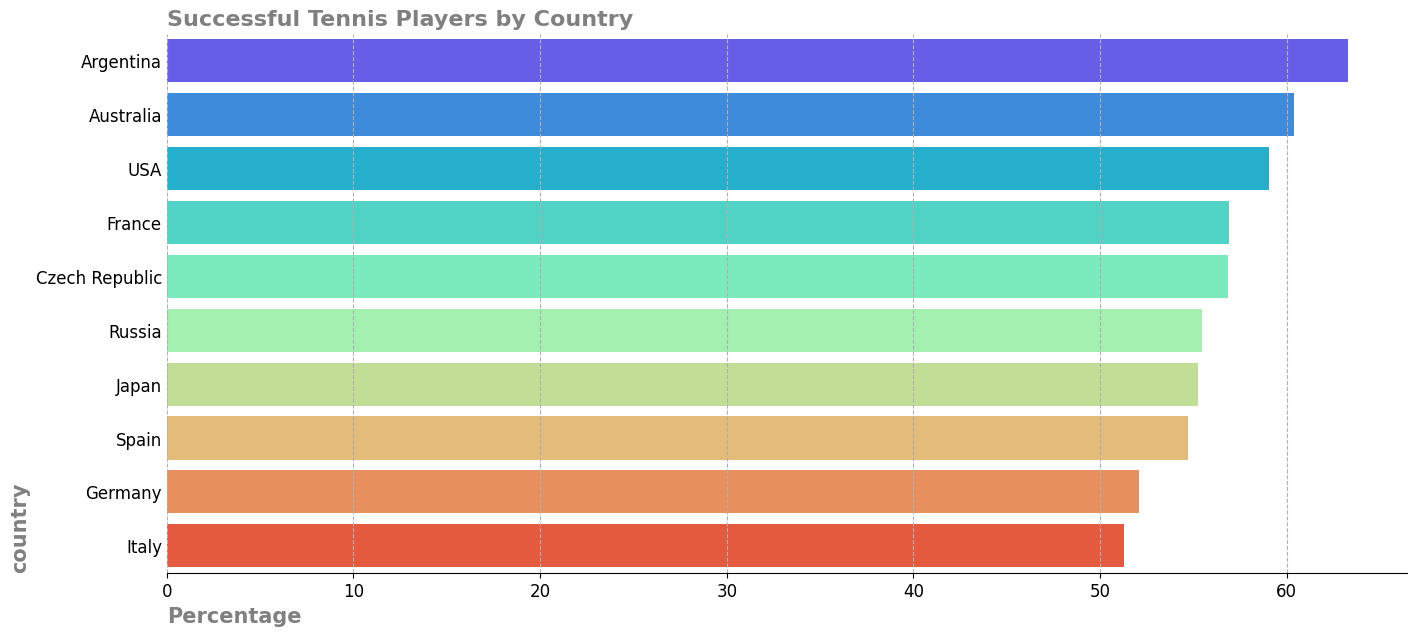

In [ ]:
# Read away\home team data with required columns
df_away_team = pd.read_csv(f"tennis_data/away_team.csv")[['match_id','full_name','country']]
df_home_team = pd.read_csv(f"tennis_data/home_team.csv")[['match_id','full_name','country']]

# Read event data including winner code
df_event = pd.read_csv(f"tennis_data/event.csv")

# Add a column to distinguish team type
df_away_team['team_type'] = 'away'
df_home_team['team_type'] = 'home'

# Merge home and away team data on match_id; use suffixes to distinguish home/away columns and remove duplicate matches
players = df_home_team.merge(df_away_team, on='match_id', suffixes=['_home','_away'], how='outer')
players.drop_duplicates(subset='match_id', inplace=True)

# Merge players with event results to include winner information and drop rows with missing winner or country information
merge_df = players.merge(df_event[['match_id', 'winner_code']], on='match_id')
merge_df.dropna(subset=['winner_code','country_home','country_away'], inplace=True)

# Create boolean columns to indicate if home/away player won
merge_df['is_winner_home'] = (merge_df['winner_code'] == 1) & (merge_df['team_type_home'] == 'home')
merge_df['is_winner_away'] = (merge_df['winner_code'] == 2) & (merge_df['team_type_away'] == 'away')

# Remove duplicates after winner calculations
merge_df.drop_duplicates(subset='match_id', inplace=True)

# Aggregate wins for home players
final_df_home = merge_df.groupby(['match_id', 'full_name_home', 'country_home']).agg(
    wins=('is_winner_home', 'sum')
).reset_index()

# Aggregate wins for away players
final_df_away = merge_df.groupby(['match_id', 'full_name_away', 'country_away']).agg(
    wins=('is_winner_away', 'sum')
).reset_index()

# Standardize column names to combine home and away stats
final_df_home.rename(columns={'full_name_home':'full_name','country_home':'country'}, inplace=True)
final_df_away.rename(columns={'full_name_away':'full_name','country_away':'country'}, inplace=True)

# Combine home and away stats, calculate total matches and wins per country
final_df = pd.concat([final_df_home, final_df_away]).groupby('country').agg(
    total_match=('match_id','nunique'),
    total_wins=('wins','sum')
).reset_index()

# Sort countries by total wins
final_df.sort_values(by='total_wins', ascending=False, inplace=True)

# Calculate win percentage per country
final_df['Percentage'] = (final_df['total_wins'] / final_df['total_match'] * 100).round(2)

# Keep top 10 countries
final_df = final_df.head(10)

# Sort top countries by win percentage
final_df.sort_values(by='Percentage', ascending=False, inplace=True)

# Reset index to start from 1
final_df = final_df.reset_index(drop=True)
final_df.index = final_df.index + 1

# Added plot
fig, ax =plt.subplots(figsize=(16,7))
sns.barplot(x='Percentage', y='country', data=final_df, palette='rainbow')
ax.spines[['left','top','right']].set_visible(False)
ax.set_title('Successful Tennis Players by Country',
             loc='left',
             weight='bold',
             color='gray',
             fontsize=16)
ax.set_xlabel('Percentage',
              loc='left',
              weight='bold',
              color='gray',
              fontsize=15)

ax.set_ylabel('country',
              loc='bottom',
              weight='bold',
              color='gray',
              fontsize=15)

ax.tick_params(axis='y',labelsize='large')
ax.tick_params(axis='x',labelsize='large')

ax.tick_params(axis='y',which='major',length=0)
ax.grid(axis='x',linestyle='dashed')
plt.show()